<a href="https://colab.research.google.com/github/buthaina279/P4DS/blob/main/COMP5623M_CW2v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## OCOM5203M Practical Assignment 2 - Image Caption Generation [100 marks]

The maximum number of marks for each part are shown in the section headers. As indicated in the main heading above, the overall assessment carries a maximum of 100 marks.

This summative assessment is weighted 25% of the final grade for the module.

### Motivation 

Through this coursework, you will:

> 1. Understand the principles of text pre-processing and vocabulary building.
> 2. Gain experience working with an image to text model.
> 3. Use and compare two different text similarity metrics for evaluating an image to text model, and understand evaluation challenges.


### Setup and resources 

Having a GPU will speed up the image feature extraction process. If you would like to use a GPU, please refer to the module website for recommended working environments with GPUs.

Please implement the coursework using Python and PyTorch, and refer to the notebooks and exercises provided.

This coursework will use a subset of the [COCO "Common Objects in Context" dataset](https://cocodataset.org/) for image caption generation. COCO contains 330K images, of 80 object categories, and at least five textual reference captions per image. Our subset consists of 5029 of these images, each of which has five or more different descriptions of the salient entities and activities, and we will refer to it as COCO_5029.

To download the data:

> 1. **Images**: download the zip file "coco_subset_images.zip (812MB)" [here](https://leeds365-my.sharepoint.com/:f:/g/personal/scsrss_leeds_ac_uk/EnVzgHGd-fhIhTcnxdK5hawBpGQz9isq8Bo8-Xhlwf6uwQ?e=e3LEru).
> 2. **Reference captions**: on the COCO [download page](https://cocodataset.org/#download), download the file named "2017 Train/Val annotations (241MB)". 
> 3. **Image meta data**: as our set is a subset of full COCO dataset, we have created a CSV file containing relevant meta data for our particular subset of images. You can download it also from Drive, "coco_subset_meta.csv" at the same link as 1.


### Submission

Please submit the following:

> 1. Your completed Jupyter notebook file, in .ipynb format. **Do not change the file name or the automatic grading will be affected.**
> 2. The .html version of your notebook; File > Download as > HTML (.html). Check that all cells have been run and all outputs (including all graphs you would like to be marked) displayed in the .html for marking.


Final note:

> **Please include in this notebook everything that you would like to be marked, including figures. Under each section, put the relevant code containing your solution. You may re-use functions you defined previously, but any new code must be in the relevant section.** Feel free to add as many code cells as you need under each section.

Your student username:

In [ ]:
ml20baya

Your full name:

In [ ]:
Buthaina Abdullah Alshareef

## Imports

Feel free to add to this section as needed.

In [1]:
import torch
import torch.nn as nn
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import os
import numpy as np
from PIL import Image
from torchvision import datasets, transforms,utils
import json

Detect which device (CPU/GPU) to use.

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


The basic principle of our image-to-text model is as pictured in the diagram below, where an Encoder network encodes the input image as a feature vector by providing the outputs of the last fully-connected layer of a pre-trained CNN (we use [ResNet-152](https://arxiv.org/abs/1512.03385)). This pretrained network has been trained on the complete ImageNet dataset and is thus able to recognise common objects. 

These features are then fed into a Decoder network along with the reference captions. As the image feature dimensions are large and sparse, the Decoder network includes a linear layer which downsizes them, followed by a batch normalisation layer to speed up training. Those resulting features, as well as the reference text captions, are passed into a recurrent network (we will use an RNN). 

The reference captions used to compute loss are represented as numerical vectors via an embedding layer whose weights are learned during training.

![Encoder Decoder](encoder_decoder_diagramv2022.png)

The Encoder-Decoder network could be coupled and trained end-to-end, without saving features to disk; however, this requires iterating through the entire image training set during training. We can make the training more efficient by decoupling the networks. 

We will first extract the feature representations of the images from the Encoder and save them (Part 1). During training of the Decoder (Part 3), we only need to iterate over the image feature data and the reference captions.

### Overview

> 1. Extracting image features 
> 2. Text preparation of training and validation data 
> 3. Training the decoder
> 4. Generating predictions on test data
> 5. Caption evaluation via BLEU score
> 6. Caption evaluation via Cosine similarity
> 7. Comparing BLEU and Cosine similarity



## 1 Extracting image features [11 marks]

### 1.1 EncoderCNN

Read through the template EncoderCNN class below and complete the class.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#for google drive
ROOT = "/content/drive/MyDrive/CW2_AI/"

In [ ]:
#for laptop
ROOT = "/Users/macbookpro/Google Drive/CW2_AI/"

In [5]:
class EncoderCNN(nn.Module):
    def __init__(self):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        self.resnet_remove = torch.nn.Sequential(*(list(resnet.children())[:-1]))

        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
          features = self.resnet_remove(images)
        features = features.reshape(features.size(0), -1)
        
        
        return features 


In [6]:
# instantiate encoder and put into evaluation mode.
encoder = EncoderCNN().to(device)
encoder.eval()

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

EncoderCNN(
  (resnet_remove): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Co

### 1.2 Processing the images

Pass the images through the ```Encoder``` model, saving the resulting features for each image. You may like to use a ```Dataset``` and ```DataLoader``` to load the data in batches for faster processing, or you may choose to simply read in one image at a time from disk without any loaders.

Note that as this is a forward pass only, no gradients are needed. You will need to be able to match each image ID (the image name without file extension) with its features later, so we suggest either saving a dictionary of image ID: image features, or keeping a separate ordered list of image IDs.

Use this ImageNet transform provided.

In [7]:
data_transform = transforms.Compose([ 
    transforms.ToTensor(),
    transforms.Resize(224), 
    transforms.CenterCrop(224), 
    transforms.Normalize((0.485, 0.456, 0.406),   # using ImageNet norms
                         (0.229, 0.224, 0.225))])

In [9]:
class COCO_dataset(Dataset):
    def __init__(self, df, transform = None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        img = Image.open(self.df['path'][index])
        file_loc = self.df['path'][index]
        file_name = file_loc.split('/')[-1]
        
        try:
            img = img.convert('RGB')
            
        except:
            pass
        
        if self.transform:
            img = self.transform(img)
        return img, file_name.replace('.jpg','')

In [10]:
coco_dir = ROOT + "images"
img_paths= []
img_name= []

for entry in os.scandir(coco_dir):
    if (entry.is_file()):
        img_paths.append(entry.path)
        img_name.append(entry.name)



data = {'path': img_paths}

coco_df = pd.DataFrame(data, columns=['path'])


print("COCO images length = ", len(coco_df), "image")
print(coco_df.head())

coco_dataset = COCO_dataset(
    df=coco_df,
    transform=data_transform,
)

coco_loader = DataLoader(
    coco_dataset,
    batch_size=15,
    shuffle=False,
    num_workers=6
)

COCO images length =  5029 image
                                                path
0  /content/drive/MyDrive/CW2_AI/images/000000516...
1  /content/drive/MyDrive/CW2_AI/images/000000540...
2  /content/drive/MyDrive/CW2_AI/images/000000368...
3  /content/drive/MyDrive/CW2_AI/images/000000205...
4  /content/drive/MyDrive/CW2_AI/images/000000229...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


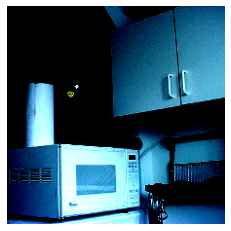

000000516212


In [11]:
img, img_id = next(iter(coco_loader))
xa = np.transpose(img[0].numpy(),(1,2,0))
plt.imshow(xa)
plt.axis('off')
plt.show()
print(img_id[0])


In [13]:
features_tensors = []
img_id_map = {}

with torch.no_grad():
  for data in coco_loader:
    img, img_id = data
    img = img.to(device)
    features = encoder(img)

    for img_id,feature in zip(img_id, features):
      img_id_map[img_id] = feature
      features_tensors.append(feature)

torch.save(features_tensors, ROOT+'features_tensors.pt')
torch.save(img_id_map, ROOT+'imgid_features_map.pt')

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## 2 Text preparation [23 marks]


### 2.1 Build the caption dataset

All our selected COCO_5029 images are from the official 2017 train set.

The ```coco_subset_meta.csv``` file includes the image filenames and unique IDs of all the images in our subset. The ```id``` column corresponds to each unique image ID.

The COCO dataset includes many different types of annotations: bounding boxes, keypoints, reference captions, and more. We are interested in the captioning labels. Open ```captions_train2017.json``` from the zip file downloaded from the COCO website. You are welcome to come up with your own way of doing it, but we recommend using the ```json``` package to initially inspect the data, then the ```pandas``` package to look at the annotations (if you read in the file as ```data```, then you can access the annotations dictionary as ```data['annotations']```).

Use ```coco_subset_meta.csv``` to cross-reference with the annotations from ```captions_train2017.json``` to get all the reference captions for each image in COCO_5029.

For example, you may end up with data looking like this (this is a ```pandas``` DataFrame, but it could also be several lists, or some other data structure/s):

<img src="df_caption_set.png" alt="images matched to caption" width="700"/>

In [14]:
#read csv data

coco_csv = pd.read_csv(ROOT+'coco_subset_meta.csv',index_col=0)

coco_csv.shape

(8000, 8)

In [15]:
coco_csv.head()

,license,file_name,coco_url,height,width,date_captured,flickr_url,id
0,2,000000262145.jpg,http://images.cocodataset.org/train2017/000000...,427,640,2013-11-20 02:07:55,http://farm8.staticflickr.com/7187/6967031859_...,262145
1,1,000000262146.jpg,http://images.cocodataset.org/train2017/000000...,640,480,2013-11-19 23:07:16,http://farm6.staticflickr.com/5090/5341741494_...,262146
2,3,000000524291.jpg,http://images.cocodataset.org/train2017/000000...,426,640,2013-11-18 09:59:07,http://farm2.staticflickr.com/1045/934293170_d...,524291
3,1,000000262148.jpg,http://images.cocodataset.org/train2017/000000...,512,640,2013-11-20 05:50:03,http://farm5.staticflickr.com/4028/4549977479_...,262148
4,3,000000393223.jpg,http://images.cocodataset.org/train2017/000000...,480,640,2013-11-21 20:08:57,http://farm1.staticflickr.com/28/45521803_c5cb...,393223


In [16]:
json_file = open(ROOT + 'annotations/captions_train2017.json')

data = json.load(json_file)

json_file.close()

In [19]:
cap_ann_df = pd.DataFrame(data['annotations'])

In [20]:
cap_ann_df.head()

,image_id,id,caption
0,203564,37,A bicycle replica with a clock as the front wh...
1,322141,49,A room with blue walls and a white sink and door.
2,16977,89,A car that seems to be parked illegally behind...
3,106140,98,A large passenger airplane flying through the ...
4,106140,101,There is a GOL plane taking off in a partly cl...


In [21]:
Caption_df = pd.merge(coco_csv,cap_ann_df, left_on = 'id', right_on = 'image_id', how = 'inner')

Caption_df = Caption_df[['image_id', 'id_y', 'caption', 'file_name']]

Caption_df.drop_duplicates(inplace = True)

In [22]:
Caption_df

,image_id,id_y,caption,file_name
0,262145,694,People shopping in an open market for vegetables.,000000262145.jpg
1,262145,1054,An open market full of people and piles of veg...,000000262145.jpg
2,262145,1456,People are shopping at an open air produce mar...,000000262145.jpg
3,262145,5248,Large piles of carrots and potatoes at a crowd...,000000262145.jpg
4,262145,5254,People shop for vegetables like carrots and po...,000000262145.jpg
...,...,...,...,...
40008,80067,782335,a dog that has a tooth brush in his mouth,000000080067.jpg
40009,80067,782578,Dog with a tooth brush in mouth in floor,000000080067.jpg
40010,80067,784051,Small gray and black dog holding a toothbrush ...,000000080067.jpg
40011,80067,784456,a close up o a dog with a tooth brush in its m...,000000080067.jpg


### 2.2 Clean the captions

Create a cleaned version of each caption. If using dataframes, we suggest saving the cleaned captions in a new column; otherwise, if you are storing your data in some other way, create data structures as needed. 

**A cleaned caption should be all lowercase, and consist of only alphabet characters.**

Print out 10 original captions next to their cleaned versions to facilitate marking.

In [23]:
Caption_df.head()

,image_id,id_y,caption,file_name
0,262145,694,People shopping in an open market for vegetables.,000000262145.jpg
1,262145,1054,An open market full of people and piles of veg...,000000262145.jpg
2,262145,1456,People are shopping at an open air produce mar...,000000262145.jpg
3,262145,5248,Large piles of carrots and potatoes at a crowd...,000000262145.jpg
4,262145,5254,People shop for vegetables like carrots and po...,000000262145.jpg


In [24]:
import re

Caption_df['cleaned_caption'] = ""

for index, row in Caption_df.iterrows():

  cap_lower = row["caption"].lower()
  cap_lower = re.sub('[^a-z]+', ' ', cap_lower)
  Caption_df['cleaned_caption'][index] = cap_lower

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [28]:
Caption_df[['caption', 'cleaned_caption']].head(10)

,caption,cleaned_caption
0,People shopping in an open market for vegetables.,people shopping in an open market for vegetables
1,An open market full of people and piles of veg...,an open market full of people and piles of veg...
2,People are shopping at an open air produce mar...,people are shopping at an open air produce mar...
3,Large piles of carrots and potatoes at a crowd...,large piles of carrots and potatoes at a crowd...
4,People shop for vegetables like carrots and po...,people shop for vegetables like carrots and po...
15,a person skiing down a steep hill,a person skiing down a steep hill
16,A person skiing down a steep snowy hill.,a person skiing down a steep snowy hill
17,A person on snow skis going down a steep slope.,a person on snow skis going down a steep slope
18,A skier is skiing down a down hill slope.,a skier is skiing down a down hill slope
19,A skier is shown taking on a very steep slope.,a skier is shown taking on a very steep slope


In [29]:
Caption_df.shape

(25154, 5)

In [30]:
Caption_df.to_csv(ROOT+"cleaned_captions.csv", encoding='utf-8', index=False)

### 2.3  Split the data

Split the data 70/10/20% into train/validation/test sets. **Be sure that each unique image (and all corresponding captions) only appear in a single set.**

We provide the function below which, given a list of unique image IDs and a 3-split ratio, shuffles and returns  a split of the image IDs.

If using a dataframe, ```df['image_id'].unique()``` will return the list of unique image IDs.

In [5]:
import random
import math

def split_ids(image_id_list, train=.7, valid=0.1, test=0.2):
    """
    Args:
        image_id_list (int list): list of unique image ids
        train (float): train split size (between 0 - 1)
        valid (float): valid split size (between 0 - 1)
        test (float): test split size (between 0 - 1)
    """
    #list_copy = image_id_list.copy()

    list_copy = caption_df['image_id'].unique().copy()
    random.shuffle(list_copy)
    
    train_size = math.floor(len(list_copy) * train)
    valid_size = math.floor(len(list_copy) * valid)
    
    return list_copy[:train_size], list_copy[train_size:(train_size + valid_size)], list_copy[(train_size + valid_size):]

In [6]:
caption_df = pd.read_csv(ROOT + 'cleaned_captions.csv') # remove unamed column

caption_df

,image_id,id_y,caption,file_name,cleaned_caption
0,262145,694,People shopping in an open market for vegetables.,000000262145.jpg,people shopping in an open market for vegetables
1,262145,1054,An open market full of people and piles of veg...,000000262145.jpg,an open market full of people and piles of veg...
2,262145,1456,People are shopping at an open air produce mar...,000000262145.jpg,people are shopping at an open air produce mar...
3,262145,5248,Large piles of carrots and potatoes at a crowd...,000000262145.jpg,large piles of carrots and potatoes at a crowd...
4,262145,5254,People shop for vegetables like carrots and po...,000000262145.jpg,people shop for vegetables like carrots and po...
...,...,...,...,...,...
25149,80067,782335,a dog that has a tooth brush in his mouth,000000080067.jpg,a dog that has a tooth brush in his mouth
25150,80067,782578,Dog with a tooth brush in mouth in floor,000000080067.jpg,dog with a tooth brush in mouth in floor
25151,80067,784051,Small gray and black dog holding a toothbrush ...,000000080067.jpg,small gray and black dog holding a toothbrush ...
25152,80067,784456,a close up o a dog with a tooth brush in its m...,000000080067.jpg,a close up o a dog with a tooth brush in its m...


In [33]:
caption_df.columns

Index(['image_id', 'id_y', 'caption', 'file_name', 'cleaned_caption'], dtype='object')

In [7]:
train_set, valid_set, test_set = split_ids(caption_df['image_id'].unique())

In [8]:
train_df = caption_df[caption_df['image_id'].isin(train_set)].reset_index()
valid_df = caption_df[caption_df['image_id'].isin(valid_set)].reset_index()
test_df = caption_df[caption_df['image_id'].isin(test_set)].reset_index()

In [9]:
print("train_df shape:", train_df.shape)
print("valid_df shape:", valid_df.shape)
print("test_df shape:", test_df.shape)

train_df shape: (17607, 6)
valid_df shape: (2512, 6)
test_df shape: (5035, 6)


In [137]:
train_df.head(5)

,index,image_id,id_y,caption,file_name,cleaned_caption
0,5,262146,634780,a person skiing down a steep hill,000000262146.jpg,a person skiing down a steep hill
1,6,262146,637393,A person skiing down a steep snowy hill.,000000262146.jpg,a person skiing down a steep snowy hill
2,7,262146,640348,A person on snow skis going down a steep slope.,000000262146.jpg,a person on snow skis going down a steep slope
3,8,262146,641836,A skier is skiing down a down hill slope.,000000262146.jpg,a skier is skiing down a down hill slope
4,9,262146,649789,A skier is shown taking on a very steep slope.,000000262146.jpg,a skier is shown taking on a very steep slope


In [37]:
valid_df.head(5)

,index,image_id,id_y,caption,file_name,cleaned_caption
0,50,262161,663851,Large motorcycle sitting on a grassy area in a...,000000262161.jpg,large motorcycle sitting on a grassy area in a...
1,51,262161,664541,Older motorcycle displayed on grass along with...,000000262161.jpg,older motorcycle displayed on grass along with...
2,52,262161,665543,A motorcycle that is parked in a field.,000000262161.jpg,a motorcycle that is parked in a field
3,53,262161,666083,Several motorcycles and cars sitting on a gras...,000000262161.jpg,several motorcycles and cars sitting on a gras...
4,54,262161,667574,A number of motorbikes and cars parked in the ...,000000262161.jpg,a number of motorbikes and cars parked in the ...


In [38]:
test_df.head(5)

,index,image_id,id_y,caption,file_name,cleaned_caption
0,30,524297,357165,A vintage photo of two men and a lama.,000000524297.jpg,a vintage photo of two men and a lama
1,31,524297,361053,A black and white image of two guys and a bear.,000000524297.jpg,a black and white image of two guys and a bear
2,32,524297,364968,Two people standing in the middle of an empty ...,000000524297.jpg,two people standing in the middle of an empty ...
3,33,524297,368067,A bear sits down between the two men.,000000524297.jpg,a bear sits down between the two men
4,34,524297,370326,And old picture of two men standing in the roa...,000000524297.jpg,and old picture of two men standing in the roa...


### 2.3 Building the vocabulary

The vocabulary consists of all the possible words which can be used - both as input into the model, and as output predictions, and we will build it using the cleaned words found in the reference captions from the training set. In the vocabulary each unique word is mapped to a unique integer (a Python ```dictionary``` object).

A ```Vocabulary``` object is provided for you below to use.

In [10]:
class Vocabulary(object):
    """ Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # intially, set both the IDs and words to dictionaries with special tokens
        self.word2idx = {'<pad>': 0, '<unk>': 1, '<end>': 2}
        self.idx2word = {0: '<pad>', 1: '<unk>', 2: '<end>'}
        self.idx = 3

    def add_word(self, word):
        # if the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # increment the ID for the next word
            self.idx += 1

    def __call__(self, word):
        # if we try to access a word not in the dictionary, return the id for <unk>
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)


Collect all words from the cleaned captions in the **training and validation sets**, ignoring any words which appear 3 times or less; this should leave you with roughly 2200 words (plus or minus is fine). As the vocabulary size affects the embedding layer dimensions, it is better not to add the very infrequently used words to the vocabulary.

Create an instance of the ```Vocabulary()``` object and add all your words to it.

In [11]:
from collections import Counter

all_vocab_list = []
remove_freq_vocab = []

for caption in train_df['cleaned_caption']:
  cap_vocab_list= caption.split(' ')
  all_vocab_list.extend(cap_vocab_list)

for caption in valid_df['cleaned_caption']:
  cap_vocab_list= caption.split(' ')
  all_vocab_list.extend(cap_vocab_list)
    

dict_vocab = Counter(all_vocab_list)

for key, value in dict_vocab.items():
        if value >3:
          remove_freq_vocab.append(key)

remove_freq_vocab = set(remove_freq_vocab)
vocab = Vocabulary()
for word in remove_freq_vocab:
  vocab.add_word(word)

In [12]:
print("vocabulary length: ", len(remove_freq_vocab))
print("index vocabulary length: ", vocab.idx)

vocabulary length:  2416
index vocabulary length:  2419


### 2.4 The Dataset and DataLoader

Create a PyTorch ```Dataset``` class and a corresponding ```DataLoader``` for the inputs to the decoder. Create three sets: one each for training, validation, and test. Set ```shuffle=True``` for the training set DataLoader.

The ```Dataset``` function ```__getitem__(self, index)``` should return three Tensors:

>1. A Tensor of image features, dimension (1, 4096).
>2. A Tensor of integer word ids representing the reference caption; use your ```Vocabulary``` object to convert each word in the caption to a word ID. Be sure to add the word ID for the ```<unk>``` token at the end of each caption, then fill in the the rest of the caption with the ```<pad>``` token so that each caption has uniform lenth (max sequence length) of **47**.
>3. A Tensor of integers representing the true lengths of every caption in the batch (include the ```<end>``` token in the count).


Note that as each unique image has five or more (say, ```n```) reference captions, each image feature will appear ```n``` times, once in each unique (feature, caption) pair.

In [13]:
class COCO_Subset(Dataset):
    """ COCO subset custom dataset, compatible with torch.utils.data.DataLoader. """
    
    def __init__(self, df, features, vocab):
        """
        Args:
            df: (dataframe or some other data structure/s you may prefer to use)
            features: image features
            vocab: vocabulary wrapper
           
        """
        self.df = df
        self.features = features
        self.vocab = vocab

    
    def __getitem__(self, index):
        
        """ Returns one data tuple (feature [1, 2048], target caption of word IDs [1, 47], and integer true caption length) """ 
        #image features
        img_id_df = self.df['file_name'][index].replace('.jpg','')
        img_features = self.features[img_id_df]

        #captions 
        caption = self.df["cleaned_caption"].iloc[index]
        tokens = caption.split()
        caption = []
        caption.extend([vocab(token) for token in tokens])
        caption.append(vocab('<end>'))
        
        #original length with <end>
        len_cap = len(caption)

        #to reach 47
        len_cap_47  = 47 - len_cap
        caption.extend([self.vocab('<pad>') for i in range(len_cap_47)])
        target = torch.tensor(caption)
        
        return img_features, target, len_cap
      
    def __len__(self):
        return len(self.df)
    

In [14]:
#Train loader 
results_path = ROOT+ "imgid_features_map.pt"
features = torch.load(results_path)

train_dataset = COCO_Subset(
    df = train_df,
    features = features,
    vocab = vocab
)

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,
    num_workers=0)



Load one batch of the training set and print out the shape of each returned Tensor.

In [15]:
train_iter = iter(train_loader)

features, captions, lengths = train_iter.next()

print(features.shape)
print(captions.shape)
print(lengths.shape)

torch.Size([64, 2048])
torch.Size([64, 47])
torch.Size([64])


In [16]:
#valid loader
results_path = ROOT+ "imgid_features_map.pt"
features = torch.load(results_path)

valid_dataset = COCO_Subset(
    df = valid_df,
    features = features,
    vocab = vocab
)

valid_loader = DataLoader(
    valid_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=0
)




In [17]:
valid_iter = iter(valid_loader)
features, captions, lengths = valid_iter.next()


print(features.shape)
print(captions.shape)
print(lengths.shape)

torch.Size([64, 2048])
torch.Size([64, 47])
torch.Size([64])


In [18]:
#test loader

results_path = ROOT+ "imgid_features_map.pt"
features = torch.load(results_path)

test_dataset = COCO_Subset(
    df = test_df,
    features = features,
    vocab = vocab
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,
    num_workers=0
)




In [19]:
test_iter = iter(test_loader)
features, captions, lengths = test_iter.next()


print(features.shape)
print(captions.shape)
print(lengths.shape)

torch.Size([64, 2048])
torch.Size([64, 47])
torch.Size([64])


## 3 Train DecoderRNN [15 marks]

### 3.1 Define the encoder model

Read through the ```DecoderRNN``` model below. First, complete the decoder by adding an ```rnn``` layer to the decoder where indicated, using [the PyTorch API as reference](https://pytorch.org/docs/stable/nn.html#rnn).

Keep all the default parameters except for ```batch_first```, which you may set to True.

In particular, understand the meaning of ```pack_padded_sequence()``` as used in ```forward()```. Refer to the [PyTorch ```pack_padded_sequence()``` documentation](https://pytorch.org/docs/stable/generated/torch.nn.utils.rnn.pack_padded_sequence.html).


In [20]:
class DecoderRNN(nn.Module):
    def __init__(self, vocab_size, embed_size=256, hidden_size=512, num_layers=1, max_seq_length=47):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        # we want a specific output size, which is the size of our embedding, so
        # we feed our extracted features from the last fc layer (dimensions 1 x 2048)
        # into a Linear layer to resize
        self.resize = nn.Linear(2048, embed_size)
        
        # batch normalisation helps to speed up training
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)

        # What is an embedding layer?
        self.embed = nn.Embedding(vocab_size, embed_size)

        # TO COMPLETE
        # self.rnn = 
        #Applies a multi-layer Elman RNN with tanh  or ReLU  non-linearity to an input sequence.
        self.rnn = nn.RNN(embed_size, hidden_size, num_layers, batch_first=True)

        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seq_length = max_seq_length
        

    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        im_features = self.resize(features)
        im_features = self.bn(im_features)
        
        embeddings = torch.cat((im_features.unsqueeze(1), embeddings), 1)
    
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True, enforce_sorted=False) 
        # pack_padded_sequence returns a PackedSequence object, which contains two items: 
        # the packed data (data cut off at its true length and flattened into one list), and 
        # the batch_sizes, or the number of elements at each sequence step in the batch.
        # For instance, given data [a, b, c] and [x] the PackedSequence would contain data 
        # [a, x, b, c] with batch_sizes=[2,1,1].
        
        hiddens, _ = self.rnn(packed)
        outputs = self.linear(hiddens.data) # hiddens[0]
        return outputs
    
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []

        inputs = self.bn(self.resize(features)).unsqueeze(1)
        for i in range(self.max_seq_length):
            hiddens, states = self.rnn(inputs, states)  # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))   # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)               # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)              # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)       # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids
    

In [21]:
# instantiate decoder
decoder = DecoderRNN(len(vocab)).to(device)

### 3.2 Train the decoder

Train the decoder by passing the features, reference captions, and targets to the decoder, then computing loss based on the outputs and the targets. Note that when passing the targets and model outputs to the loss function, the targets will also need to be formatted using ```pack_padded_sequence()```.

We recommend a batch size of around 64 (though feel free to adjust as necessary for your hardware).

**We strongly recommend saving a checkpoint of your trained model after training so you don't need to re-train multiple times.**

Display a graph of training and validation loss over epochs to justify your stopping point.

In [22]:
loss_fn = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

In [23]:
# display the loss of training and validation 

def display_train_valid_loss(file_dr):

  results_path = ROOT + file_dr
  data = torch.load(results_path)
  statsrec = data["stats"]

  fig, ax1 = plt.subplots()
  plt.plot(statsrec[0], 'r', label = 'training loss', )
  plt.plot(statsrec[1], 'g', label = 'Validation loss' )
  plt.legend(loc='lower right')
  plt.xlabel('epoch')
  plt.ylabel('loss')
  plt.title('Training and Validation Loss')
  plt.show()

In [24]:
# Define status function

def status(loader, net):

  correct = 0
  total = 0
  running_loss = 0
  n = 0

  #decoder.eval()
  with torch.no_grad():
    for data in loader:
      features, captions, lengths = data

      features = features.to(device)
      captions = captions.to(device)

      outputs = decoder(features, captions, lengths)

      targets = pack_padded_sequence(captions, lengths, batch_first=True, enforce_sorted=False)[0]

      # accumulate loss

      running_loss += loss_fn(outputs, targets) #targets

      n += 1

  return running_loss/n

In [25]:
epochs = 5

cal_loss = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(decoder.parameters(), lr=0.002)

statsrec = np.zeros((2,epochs))

decoder_results = 'decoder_results_5epochs.pt'

results_path = ROOT + decoder_results

for epoch in range(epochs):
  running_loss = 0.0
  n = 0

  for data in train_loader:
    features, captions, lengths = data

    features = features.to(device)
    captions = captions.to(device)

    targets = pack_padded_sequence(captions, lengths, batch_first=True, enforce_sorted=False)[0]

    outputs = decoder(features, captions, lengths)

    loss = loss_fn(outputs, targets)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    running_loss+= loss.item()

    n+=1

  loss_train = running_loss/n

  loss_valid = status(valid_loader, decoder)

  statsrec[:,epoch] = (loss_train, loss_valid.cpu())

  print('Epoch [{}], Training Loss: {:.4f}, Validation Loss: {:.4f}'.format(epoch, loss_train, loss_valid ))

torch.save({"state_dict": decoder.state_dict(), "stats": statsrec}, results_path)

Epoch [0], Training Loss: 3.8893, Validation Loss: 3.5760
Epoch [1], Training Loss: 2.9922, Validation Loss: 3.4426
Epoch [2], Training Loss: 2.7050, Validation Loss: 3.4502
Epoch [3], Training Loss: 2.4809, Validation Loss: 3.5001
Epoch [4], Training Loss: 2.2864, Validation Loss: 3.5401


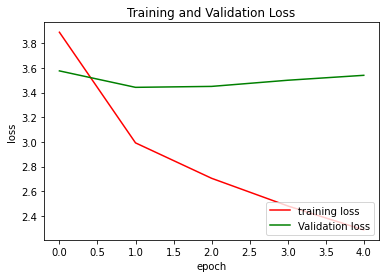

In [26]:
display_train_valid_loss('decoder_results_5epochs.pt')

## 4 Generate predictions on test data [8 marks]

Display 5 sample test images containing different objects, along with your model’s generated captions and all the reference captions for each.

> Remember that everything **displayed** in the submitted notebook and .html file will be marked, so be sure to run all relevant cells.

In [27]:
decoder.eval()

DecoderRNN(
  (resize): Linear(in_features=2048, out_features=256, bias=True)
  (bn): BatchNorm1d(256, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
  (embed): Embedding(2419, 256)
  (rnn): RNN(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=2419, bias=True)
)

In [28]:
def decode_caption(sampled_ids, vocab):
    
    predicted_caption_list = []
    sampled_ids = sampled_ids.cpu()
    
    if(torch.is_tensor(sampled_ids)):
        sampled_ids_list = sampled_ids.numpy().tolist()

    for cap_word in sampled_ids_list:
      predicted_caption = ""

      for word_id in cap_word:
        word = vocab.idx2word[word_id]
        
        if word == '<end>':
            break
        predicted_caption = predicted_caption + " " + word
      predicted_caption_list.append(predicted_caption)

    return predicted_caption_list

In [29]:
def prediction():

  #take one batch
  features, captions, lengths = next(iter(test_loader))
  features = features.to(device)
  captions = captions.to(device)
  
  features_25 = features[:25]
  with torch.no_grad():
    output = decoder.sample(features_25[::5])

  sentence = decode_caption(output, vocab)

  results_path = ROOT+ "imgid_features_map.pt"
  features_map = torch.load(results_path)

  c=0
  image_result = []

  for i in range(0, 25, 5):
    for key, value in features_map.items():
      if torch.equal(value,features_25[i]) == True:
        image_result.append(key)
        c+=1
      else:
        continue
  imagePath_list =[]
  
  for i in range(0,5):
    imagePath = ROOT + 'images/' + image_result[i] + '.jpg'
    imagePath_list.append(imagePath)
  return imagePath_list, captions, sentence

In [30]:
images, caps, predics = prediction()
captions = decode_caption(caps, vocab)

In [31]:
ref_cap1 = captions[0:5]
ref_cap2 = captions[5:10]
ref_cap3 = captions[10:15]
ref_cap4 = captions[15:20]
ref_cap5 = captions[20:25]

reference cap = [' a woman wearing a <unk> is brushing her teeth', ' a man that is holding a toothbrush in his mouth', ' a closeup of a girl brushing her teeth', ' a women brushing her teeth with her tooth brush', ' a boy brushing his teeth near a window']


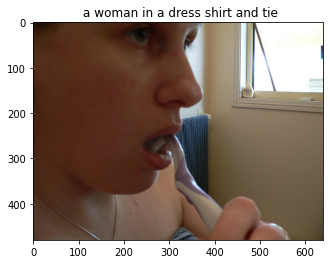

In [32]:
plt.title(predics[0])
plt.imshow(Image.open(images[0]))
print("reference cap =", ref_cap1)

reference cap = [' a vintage photo of two men and a <unk>', ' a black and white image of two guys and a bear', ' two people standing in the middle of an empty street with a bear on a rope', ' a bear sits down between the two men', ' and old picture of two men standing in the road with a bear on a chain between them']


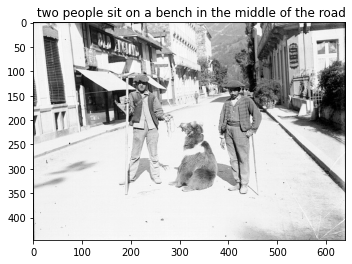

In [33]:
plt.title(predics[1])
plt.imshow(Image.open(images[1]))
print("reference cap =", ref_cap2)

reference cap = [' a man riding skis down a snow covered slope', ' someone cross country skiing in their back yard', ' a person is skiing over a snowy hill', ' a man is trying to ski down a small hill', ' a person on skis in the snow with trees in back']


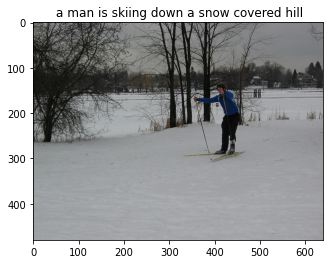

In [34]:
plt.title(predics[2])
plt.imshow(Image.open(images[2]))
print("reference cap =", ref_cap3)

reference cap = [' large motorcycle sitting on a grassy area in a line', ' older motorcycle displayed on grass along with several old cars', ' a motorcycle that is parked in a field', ' several motorcycles and cars sitting on a grassy lot', ' a number of <unk> and cars parked in the field']


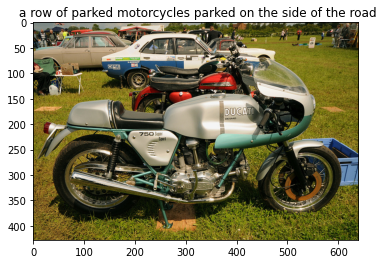

In [35]:
plt.title(predics[3])
plt.imshow(Image.open(images[3]))
print("reference cap =", ref_cap4)

reference cap = [' a young child in the yard holding up a bat', ' a boy <unk> back with a baseball bat in a yard', ' a little boy has a baseball bat in a yard', ' a boy in black clothes holds a baseball bat over his shoulder near a fence and a tree', ' a little boy playing in his yard with a baseball bat']


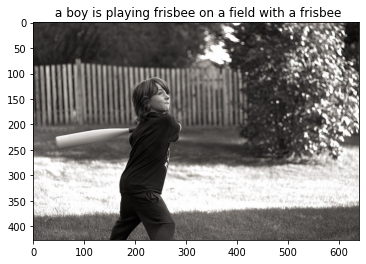

In [36]:
plt.title(predics[4])
plt.imshow(Image.open(images[4]))
print("reference cap =", ref_cap5)

## 5 Caption evaluation using BLEU score [10 marks]

There are different methods for measuring the performance of image to text models. We will evaluate our model by measuring the text similarity between the generated caption and the reference captions, using two commonly used methods. Ther first method is known as *Bilingual Evaluation Understudy (BLEU)*.

###  5.1 BLEU score


One common way of comparing a generated text to a reference text is using BLEU. This article gives a good intuition to how the BLEU score is computed: https://machinelearningmastery.com/calculate-bleu-score-for-text-python/, and you may find an implementation online to use. One option is the NLTK implementation `nltk.translate.bleu_score` here: https://www.nltk.org/api/nltk.translate.bleu_score.html


> **Tip:** BLEU scores can be weighted by ith-gram. Check that your scores make sense; and feel free to use a weighting that best matches the data. We will not be looking for specific score ranges; rather we will check that the scores are reasonable and meaningful given the captions.

Write the code to evaluate the trained model on the complete test set and calculate the BLEU score using the predictions, compared against all five references captions. 

Display a histogram of the distribution of scores over the test set.

In [ ]:
#You should ignore the tokens when comparing with reference captions. <unk>

In [33]:
# TO COMPLETE my code
unique_features_list = []
all_features_list = []
all_captions_list = []
c = 0
with torch.no_grad(): #???
  for data in test_loader:
    features, captions, lengths = data
    features = features.to(device)
    captions = captions.to(device)

    features_in_batch = features.cpu()
    features_in_batch = features_in_batch.numpy().tolist()

    captions_in_batch = captions.cpu()
    captions_in_batch = captions_in_batch.numpy().tolist()

    for feature in features_in_batch:
      all_features_list.append(feature)

    for cap in captions_in_batch:
      all_captions_list.append(cap)

for feature in all_features_list:
  if feature not in unique_features_list:
              #features_list.append(feature) 
              #if not any([(feature == features_list_).all() for features_list_ in features_list]):
    unique_features_list.append(feature)
  else:
    continue

features_bleu = torch.tensor(unique_features_list)
features_bleu = features_bleu.to(device)

cap_bleu = torch.tensor(all_captions_list)
cap_bleu = cap_bleu.to(device)


word_ids_bleu = decoder.sample(features_bleu).to(device)
predicted_cap_bleu = decode_caption(word_ids_bleu, vocab)
ref_cap_bleu = decode_caption(cap_bleu, vocab)

#create list for each pridected caption with its reference caption
ref_pre_cap = {}
counter = 0
for i in range(len(predicted_cap_bleu)):
  ref_pre_cap.setdefault(i,[]).append(predicted_cap_bleu[i].split())
  start = i*5
  end = start +5
  ref_pre_cap.setdefault(i,[]).append(ref_cap_bleu[start:end])
  ref_pre_cap[i][1] = [cap.split() for cap in ref_pre_cap[i][1]]
  #ref_pre_cap[i]= predicted_cap_bleu[i]
  #ref_pre_cap[i]= ref_cap_bleu[i]


In [33]:
len(predicted_cap_bleu)

1007

In [34]:
predicted_cap_bleu[0]

' a person skiing downhill on a snowy day'

In [179]:
len(ref_cap_bleu)

5035

In [180]:
ref_cap_bleu[0:5]

[' people shopping in an open market for vegetables',
 ' an open market full of people and piles of vegetables',
 ' people are shopping at an open air produce market',
 ' large piles of carrots and potatoes at a crowded outdoor market',
 ' people shop for vegetables like carrots and potatoes at an open air market']

In [35]:
#create list for each pridected caption with its reference caption
ref_pre_cap = {}
counter = 0
for i in range(len(predicted_cap_bleu)):
  ref_pre_cap.setdefault(i,[]).append(predicted_cap_bleu[i].split())
  start = i*5
  end = start +5
  ref_pre_cap.setdefault(i,[]).append(ref_cap_bleu[start:end])
  ref_pre_cap[i][1] = [cap.split() for cap in ref_pre_cap[i][1]]
  #ref_pre_cap[i]= predicted_cap_bleu[i]
  #ref_pre_cap[i]= ref_cap_bleu[i]


In [44]:
ref_pre_cap[0][0]

KeyError: ignored

In [183]:
ref_pre_cap[0][1]

[['people', 'shopping', 'in', 'an', 'open', 'market', 'for', 'vegetables'],
 ['an',
  'open',
  'market',
  'full',
  'of',
  'people',
  'and',
  'piles',
  'of',
  'vegetables'],
 ['people', 'are', 'shopping', 'at', 'an', 'open', 'air', 'produce', 'market'],
 ['large',
  'piles',
  'of',
  'carrots',
  'and',
  'potatoes',
  'at',
  'a',
  'crowded',
  'outdoor',
  'market'],
 ['people',
  'shop',
  'for',
  'vegetables',
  'like',
  'carrots',
  'and',
  'potatoes',
  'at',
  'an',
  'open',
  'air',
  'market']]

In [73]:
#for each predicted sentence do sentence blue with all reference captions
from nltk.translate.bleu_score import sentence_bleu

bleu_scores_list = []
for i in range(len(ref_pre_cap)):
  bleu_score = sentence_bleu(ref_pre_cap[imagePath_list[i]][1], ref_pre_cap[imagePath_list[i]][0]) 

  bleu_scores_list.append(bleu_score)

bleu_scores_array = np.array(bleu_scores_list) 

avg_bleu_score = (bleu_scores_array.sum())/len(bleu_scores_array)


#scores_df['bleu_scores'] = bleu_score

#print(score)
#chencherry = SmoothingFunction()
#sentence_bleu([reference1, reference2, reference3], hypothesis2,smoothing_function=chencherry.method1) 

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


In [74]:
bleu_scores_array

array([0.43668354, 0.44124845, 0.53728497, ..., 0.45914977, 0.68037493,
       0.48549177])

In [75]:
print("average bleu score", avg_bleu_score)

average bleu score 0.5204219622083408


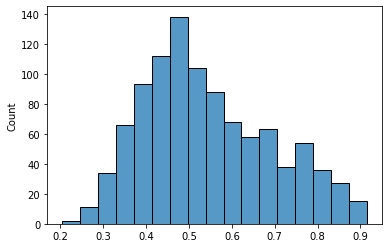

In [39]:
#Hisogram 
import seaborn as sns
#penguins = sns.load_dataset("penguins")
sns.histplot(data=bleu_scores_array)

### 5.2 BLEU score examples

Find one sample with high BLEU score and one with a low score, and display the model's predicted sentences, the BLEU scores, and the 5 reference captions.

In [ ]:
# TO COMPLETE

In [ ]:
#score = sentence_bleu(reference, capation,weights=(1,0,0,0))

In [40]:
#high score
highest_results = np.where(bleu_scores_array == max(bleu_scores_array))
print(highest_results)
one_highest_results = highest_results[0][0]
print(max(bleu_scores_array))
print(ref_pre_cap[one_highest_results][1])
print(ref_pre_cap[one_highest_results][0])

(array([60]),)
0.9146912192286945
[['the', 'new', 'small', '<unk>', 'are', 'parked', 'next', 'to', 'each', 'other'], ['a', 'woman', 'riding', 'on', 'the', 'back', 'of', 'her', '<unk>', 'motorcycle', 'while', 'wearing', 'a', '<unk>'], ['a', 'woman', 'on', 'the', 'back', 'of', 'a', 'bike', 'with', 'a', 'red', '<unk>'], ['a', 'woman', 'sitting', 'behind', 'a', 'man', 'on', 'a', 'motorcycle'], ['a', 'couple', 'riding', 'down', 'the', 'street', 'on', 'a', '<unk>', '<unk>', 'motorcycle']]
['a', 'group', 'of', 'people', 'are', 'riding', 'bikes', 'down', 'a', 'street']


In [43]:
#low score 
lowest_results = np.where(bleu_scores_array == min(bleu_scores_array))
print(lowest_results)
one_lowest_results = lowest_results[0][0]
print(min(bleu_scores_array))
print(ref_pre_cap[one_lowest_results][1])
print(ref_pre_cap[one_lowest_results][0])

NameError: ignored

In [75]:
results_path = ROOT + "imgid_features_map.pt"
mapping_dict = torch.load(results_path)
c=0
image_result = []

for i in range(len(features_bleu)):
  for key, value in mapping_dict.items():
     if torch.equal(value,features_bleu[i]) == True:
       image_result.append(key)
       c+=1
     else:
         continue

print("Image result =",image_result)



KeyboardInterrupt: ignored

In [34]:
def get_prediction():

  unique_features_list = []
  all_features_list = []
  all_captions_list = []

  for data in test_loader:
    features, captions, lengths = data
    features = features.to(device)
    captions = captions.to(device)

    # Collect all features from all batches and append to final list
    features_in_batch = features.cpu()
    features_in_batch = features_in_batch.numpy().tolist()

    captions_in_batch = captions.cpu()
    captions_in_batch = captions_in_batch.numpy().tolist()

    for feature in features_in_batch:
      all_features_list.append(feature)

    for cap in captions_in_batch:
      all_captions_list.append(cap)

  # Keep only unique features from entire feature list
  for feature in all_features_list:
   if feature not in unique_features_list:
              #features_list.append(feature) 
              #if not any([(feature == features_list_).all() for features_list_ in features_list]):
      unique_features_list.append(feature)
   else:
      continue

  # Change unique feature list and caption list to tensors
  features_bleu = torch.tensor(unique_features_list)
  features_bleu = features_bleu.to(device)

  cap_bleu = torch.tensor(all_captions_list)
  cap_bleu = cap_bleu.to(device)

  results_path = ROOT + "imgid_features_map.pt"
  mapping_dict = torch.load(results_path)
  c=0
  image_result = []

  for i in range(len(features_bleu)):
    for key, value in mapping_dict.items():
     if torch.equal(value,features_bleu[i]) == True:
       image_result.append(key)
       c+=1
     else:
         continue

  print("Image result =",image_result)
  # Generate predictions on entire test data features
  decoder.eval()
  with torch.no_grad():
    word_ids_bleu = decoder.sample(features_bleu).to(device)

  # results_path2 = ROOT + "CaptionFeatures.pt"
  # capFeat_dict = torch.load(results_path2)


  # Decode the predicted and refrence captions
  predicted_cap_bleu = decode_caption(word_ids_bleu, vocab)
  ref_cap_bleu = decode_caption(cap_bleu, vocab)

  # Create image list
  imagePath_list =[]
  
  for i in range(len(features_bleu)):
    imagePath = ROOT + 'images/' + image_result[i] + '.jpg'
    imagePath_list.append(imagePath)

  #create list for each pridected caption with its reference captions
  ref_pre_cap = {}
  counter = 0
  for i in range(len(predicted_cap_bleu)):
      ref_pre_cap.setdefault(imagePath_list[i],[]).append(predicted_cap_bleu[i].split())
      start = i*5
      end = start +5
      ref_pre_cap.setdefault(imagePath_list[i],[]).append(ref_cap_bleu[start:end])
      
      ref_pre_cap[imagePath_list[i]][1] = [cap.split() for cap in ref_pre_cap[imagePath_list[i]][1]]

  
  return imagePath_list, ref_cap_bleu, predicted_cap_bleu, ref_pre_cap

In [35]:
imagePath_list, ref_cap_bleu, predicted_cap_bleu, ref_pre_cap = get_prediction()

Image result = ['000000393224', '000000131084', '000000262161', '000000262175', '000000393268', '000000262207', '000000131174', '000000262274', '000000524436', '000000262299', '000000393418', '000000057361', '000000434200', '000000483362', '000000204887', '000000237658', '000000090218', '000000499829', '000000041079', '000000385145', '000000041085', '000000229507', '000000327819', '000000565401', '000000188575', '000000319655', '000000049327', '000000508083', '000000573627', '000000344264', '000000434380', '000000327895', '000000352478', '000000434410', '000000163866', '000000360480', '000000065584', '000000163897', '000000000064', '000000196675', '000000557127', '000000000071', '000000131162', '000000229500', '000000327808', '000000557191', '000000393412', '000000098502', '000000164040', '000000164042', '000000196811', '000000008193', '000000499731', '000000024608', '000000008238', '000000499802', '000000254046', '000000204906', '000000450666', '000000401526', '000000360573', '0000004

In [50]:
ref_pre_cap[0]

KeyError: ignored

## 6 Caption evaluation using cosine similarity [12 marks]

###  6.1 Cosine similarity

The cosine similarity measures the cosine of the angle between two vectors in n-dimensional space. The smaller the angle, the greater the similarity.

To use the cosine similarity to measure the similarity between the generated caption and the reference captions: 

* Find the embedding vector of each word in the caption 
* Compute the average vector for each caption 
* Compute the cosine similarity score between the average vector of the generated caption and average vector of each reference caption
* Compute the average of these scores 

Calculate the cosine similarity using the model's predictions over the whole test set. 

Display a histogram of the distribution of scores over the test set.

In [36]:
# TO COMPLETE
#Find the embedding vector of each word in the caption (both generated and reference?)

vocab_embeddings = decoder.embed.weight
vocab_embeddings = vocab_embeddings.detach().cpu().numpy().tolist() 

In [37]:
#same length in vocabluary class 
len(vocab_embeddings)

2419

In [44]:
vocab_embeddings[0][0]

-1.2496689558029175

In [38]:
EMBED_SIZE = 256

In [39]:
def get_average_vector(captions_list, vocab_embeddings, vocab):
  current_word_id = vocab.word2idx["<unk>"]
  sum_vector = np.zeros([EMBED_SIZE], dtype="float32")
  average_vector = np.zeros([EMBED_SIZE], dtype="float32")
  for word in captions_list:
    if word in vocab.word2idx:
      current_word_id = vocab.word2idx[word]
    else:
      current_word_id = vocab.word2idx["<unk>"]
    word_embedding = vocab_embeddings[current_word_id]
    #print(len(word_embedding))
    sum_vector = np.sum([sum_vector, word_embedding], axis =0)
  average_vector = sum_vector/len(captions_list)
  return average_vector

average_vec_pre_cap = get_average_vector(cap_bleu, vocab_embeddings, vocab)

In [ ]:
#Compute the average of these scores

In [56]:
#Calculate the cosine similarity using the model's predictions over the whole test set.

def calculate_cosine(vocab_embeddings, ref_caps_list, vocab):
  dict_result = {}
  highest_cos_value = -1
  highest_cos_image_id = 0
  lowest_cos_value = 1
  lowest_cos_image_id = 0
  image_ids_list = []
  average_cos_values_list = []


  for i in range(len(ref_pre_cap)):
    average_vec_pre_cap = get_average_vector(ref_pre_cap[imagePath_list[i]][0], vocab_embeddings, vocab)
    ref_caps_list = ref_pre_cap[imagePath_list[i]][1]
    average_vec_ref_caps_list = []
    for ref_cap in ref_caps_list:
      average_vec_ref_cap = get_average_vector(ref_cap, vocab_embeddings, vocab)
      average_vec_ref_caps_list.append(average_vec_ref_cap)

    
    average_vec_ref_caps_list = np.reshape(average_vec_ref_caps_list, [5, EMBED_SIZE])
    from sklearn.metrics.pairwise import cosine_similarity
    cos_value = cosine_similarity(np.expand_dims(average_vec_pre_cap, 0), average_vec_ref_caps_list)
    cos_value = np.squeeze(cos_value)

    # Compute the average of these scores

    average_cos_value = cos_value.sum() / len(cos_value)
    if average_cos_value > highest_cos_value:
      highest_cos_value = average_cos_value
    if average_cos_value < lowest_cos_value:
      lowest_cos_value = average_cos_value

    average_cos_values_list.append(average_cos_value)

  overall_ave_cos_value = sum(average_cos_values_list) / len(average_cos_values_list)

  return overall_ave_cos_value, average_cos_values_list





# TO COMPLETE




In [57]:
dr, avg_cos_list = calculate_cosine(vocab_embeddings, ref_pre_cap, vocab)

In [49]:
max(avg_cos_list)

0.6730181352041198

In [50]:
min(avg_cos_list)


0.042794022010545794

In [58]:
#before the normlization
avg_cos_array = np.array(avg_cos_list)
average_cos = (avg_cos_array.sum())/len(avg_cos_array)
print("average cosine", average_cos)

average cosine 0.3499816294054743


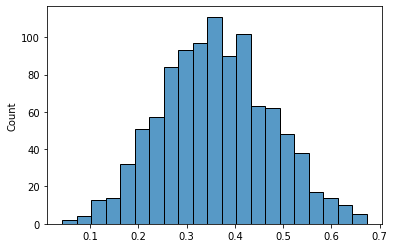

In [52]:
#Display a histogram of the distribution of scores over the test set.

sns.histplot(data=avg_cos_array)

#### 6.2 Cosine similarity examples 

Find one sample with high cosine similarity score and one with a low score, and display the model's predicted sentences, the cosine similarity scores, and the 5 reference captions.

In [60]:
# TO COMPLETE

#high score
highest_results = np.where(avg_cos_list == max(avg_cos_list))
one_highest_results = highest_results[0][0]
print(highest_results)
print(max(avg_cos_list))
print(ref_pre_cap[imagePath_list[one_highest_results]][1])
print(ref_pre_cap[imagePath_list[one_highest_results]][0])


(array([651]),)
0.7757001999938046
[['a', 'piece', 'of', 'cake', 'sitting', 'on', 'top', 'of', 'a', 'white', 'plate'], ['a', 'slice', 'of', 'chocolate', 'cake', 'with', 'chocolate', 'frosting', 'on', 'a', 'white', 'plate'], ['a', 'chocolate', 'piece', 'of', 'cake', 'that', 'is', 'on', 'a', 'plate'], ['a', 'large', 'piece', 'of', 'chocolate', 'cake', 'on', 'a', 'plate'], ['a', 'slice', 'of', 'chocolate', 'cake', 'is', 'displayed', 'on', 'a', 'plate']]
['a', 'piece', 'of', 'cake', 'on', 'a', 'white', 'plate']


In [54]:
#low score 
lowest_results = np.where(avg_cos_list == min(avg_cos_list))
one_lowest_results = lowest_results[0][0]
print(lowest_results)
print(min(avg_cos_list))
print(ref_pre_cap[one_lowest_results][1])
print(ref_pre_cap[one_lowest_results][0])

(array([210]),)
0.042794022010545794
[['a', 'boy', 'in', 'a', 'crowded', 'park', 'carrying', 'a', 'tray', 'of', 'snacks'], ['three', 'boats', 'are', 'reflected', 'on', 'shiny', 'clear', 'water'], ['three', 'boats', 'in', 'water', 'next', 'to', 'pier', 'and', '<unk>'], ['two', 'yellow', 'boats', 'and', 'one', 'blue', 'one', 'are', 'docked'], ['a', 'body', 'of', 'water', 'with', 'three', 'boats', 'sitting', 'next', 'to', 'each', 'other']]
['a', 'small', 'boat', 'is', 'going', 'down', 'the', 'canal']


## 7 Comparing BLEU and Cosine similarity [16 marks]

### 7.1 Test set distribution of scores

Compare the model’s performance on the test set evaluated using BLEU and cosine similarity and discuss some weaknesses and strengths of each method (explain in words, in a text box below). 

Please note, to compare the average test scores, you need to rescale the Cosine similarity scores [-1 to 1] to match the range of BLEU method [0.0 - 1.0].

In [61]:
# TO COMPLETE
#no need to do this 
#Rescale cosine similarity [0-1]
average_cos_values_array = np.array(avg_cos_list)
average_cos_values_array = (average_cos_values_array - np.min(average_cos_values_array))/(np.max(average_cos_values_array) - np.min(average_cos_values_array))
average_cos_values_normlized = (average_cos_values_array.sum())/len(average_cos_values_array)
print("min",min(average_cos_values_array))
print("max",max(average_cos_values_array))
print('Average_cos_values_normlized : ',average_cos_values_normlized)

min 0.0
max 1.0
Average_cos_values_normlized :  0.44878152310117253


BLEU and Cosine similarity are used to measure the similarity between the target and original sentences. BLEU scores are between 0 and 1 and it counts the matching n-grams in the sentences. Whereas Cosine similarity is the cosine of the angle between vectors, the smaller the angle, the higher the similarity, and it quantifies the similarity using the distance between two or more vectors, its values range between [-1,1] and as the value gets closer to 1, then this means the sentences are perfectly similar.
 
After the normalization, the score of cosine similarity (0.6071)  is higher than the BLEU score (0.5374) because the cosine similarity takes the meaning of the words into account.

BLEU similarity strengths:

- Simple and quick to compute 

- The interpretation of the results is easy 

- Similar to human’s approach to evaluate the same text 

- Language-independent which means it is straightforward in the application 

- Widely used and popular  

BLEU similarity weaknesses:

- Ignores the meaning of words so using synonyms like “awful” instead of “Bad” is counted as an error 

- Looking for the exact same word so for example “rain” and “raining” is considered as incorrect word 

- Does not consider the structure of the words in a sentence 

COS similarity strengths:

-Consider the meaning of words and the synonyms 

- Can be applied to most programming language 

- captures the angle of the data objects when Plotting multi-dimensional space 

COS similarity weaknesses:

- Ignores magnitude of vectors which deals with term frequency 



 ### 7.2 Analysis of individual examples
 
Find and display one example where both methods give similar scores and another example where they do not and discuss. Include both scores, predicted captions, and reference captions.

In [78]:
SIMILAR_COS_SCORE = 'similar_cos_score'
SIMILAR_BLEU_SCORE = 'similar_bleu_score'
SIMILAR_SCORE_IMAGE_ID = 'similar_score_image_id'

DISSIMILAR_COS_SCORE = 'dissimilar_cos_score'
DISSIMILAR_BLEU_SCORE = 'dissimilar_bleu_score'
DISSIMILAR_SCORE_IMAGE_ID = 'dissimilar_score_image_id'

# Check similar scores and return the scores + image_ids dictionary

def get_similar_dissimilar_score_image_id(dict_image_id_cos_value, dict_image_id_bleu_socre):
    dict_similar_dis_score_image_id = {}
    for image_id, cos_value in dict_image_id_cos_value.items():
        bleu_score = dict_image_id_bleu_socre[image_id]
        if abs(cos_value - bleu_score) < 0.05:
            # these scores are similar
            dict_similar_dis_score_image_id[SIMILAR_SCORE_IMAGE_ID] = image_id
            dict_similar_dis_score_image_id[SIMILAR_COS_SCORE] = cos_value
            dict_similar_dis_score_image_id[SIMILAR_BLEU_SCORE] = bleu_score
        if abs(cos_value - bleu_score) > 0.05:
            # these scores are dissimilar
            dict_similar_dis_score_image_id[DISSIMILAR_SCORE_IMAGE_ID] = image_id
            dict_similar_dis_score_image_id[DISSIMILAR_COS_SCORE] = cos_value
            dict_similar_dis_score_image_id[DISSIMILAR_BLEU_SCORE] = bleu_score
    return dict_similar_dis_score_image_id

In [63]:
# TO COMPLETE

def get_dict_image_id_cos_value(average_cos_values_array, image_ids_cos_list):
    dict_image_id_cos_value = {}
    for i in range(len(image_ids_cos_list)):
        image_id = image_ids_cos_list[i]
        cos_value = average_cos_values_array[i]
        dict_image_id_cos_value[image_id] = cos_value
    return dict_image_id_cos_value

Similar BLEU score:  0.345720784641941
Similar cos score:  0.3835971444197673
####################
Similar socre captions:
####################
Reference Captions:
####################
a man and woman play a video game while others watch
a group of people in a room looking at a tv
a man and a woman holding nintendo wii controllers
a group of people playing the nintendo wii
man and woman standing while others are seated looking at a monitor
####################
Generated Caption:
####################
a man and woman are standing in a living room


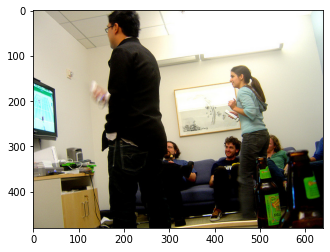

In [79]:


# Create dictionaries for cos and BLEU values
dict_image_id_cos_value=get_dict_image_id_cos_value(avg_cos_list,images)
dict_image_id_bleu_socre=get_dict_image_id_cos_value(bleu_scores_array,images)

# TO COMPLETE
# Generate similar scores, referrence captions and prediction captions

dict_similar_dis_score_image_id = get_similar_dissimilar_score_image_id(dict_image_id_cos_value,dict_image_id_bleu_socre)
# for k,v in dict_similar_dis_score_image_id.items():
#     print(k,v)
print("Similar BLEU score: ",dict_similar_dis_score_image_id['similar_bleu_score'])
print("Similar cos score: ",dict_similar_dis_score_image_id['similar_cos_score'])
sim_id =dict_similar_dis_score_image_id[SIMILAR_SCORE_IMAGE_ID]
plt.imshow(Image.open(sim_id))
#plot_image(sim_id)
print("####################")
print("Similar socre captions:")
print("####################")

print("Reference Captions:")
print("####################")
for i in ref_pre_cap[sim_id][1]:
  print(' '.join([x for x in i if x not in ('<end>','<pad>')]))

#print("Refrence captions: ", ref)
# for i in range(5):
#     ref=' '.join(map(str, ref_pred_list[sim_id][1]))
#     print("Refrence caption["+str(i)+"]: " + ref)

pred=' '.join(ref_pre_cap[sim_id][0])
print("####################")
print("Generated Caption:")
print("####################")
print(pred )



Dissimilar BLEU score:  0.537284965911771
Dissimilar cos score:  0.3286921728498481
####################
Dissimilar socre captions:
####################
Reference Captions:
####################
large motorcycle sitting on a grassy area in a line
older motorcycle displayed on grass along with several old cars
a motorcycle that is parked in a field
several motorcycles and cars sitting on a grassy lot
a number of motorbikes and cars parked in the field
####################
Generated Caption: 
a couple of motorcycles parked on a city street


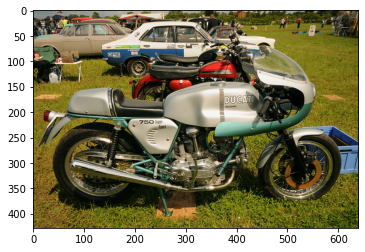

In [80]:
# Generate dissimilar scores, referrence captions and prediction captions
dict_similar_dis_score_image_id = get_similar_dissimilar_score_image_id(dict_image_id_cos_value,dict_image_id_bleu_socre)

print("Dissimilar BLEU score: ",dict_similar_dis_score_image_id['dissimilar_bleu_score'])
print("Dissimilar cos score: ",dict_similar_dis_score_image_id['dissimilar_cos_score'])

dis_id=dict_similar_dis_score_image_id[DISSIMILAR_SCORE_IMAGE_ID]
plt.imshow(Image.open(dis_id))
#plot_image(dis_id)
print("####################")
print("Dissimilar socre captions:")
print("####################")

print("Reference Captions:")
print("####################")
for i in ref_pre_cap[dis_id][1]:
  print(' '.join([x for x in i if x not in ('<end>','<pad>')]))
# for i in range(5):
#     ref=' '.join(map(str, ref_pred_list[dis_id][1]))
#     #ref=' '.join(ref_pred_list[dis_id][1])
#     print("Refrence caption["+str(i)+"]: " + ref)

pred=' '.join(ref_pre_cap[dis_id][0])
print("####################")
print("Generated Caption: " )
print(pred )

### Overall quality [5 marks]

See the top of the notebook for submission instructions.